# Lecture 7.1: Introduction to Time Series  

## Objectives  

* Identify important features on a time series plot
* Identify and interpret an AR(1) model
* Interpret an ACF
* Identify a weakly stationary time series
* Identify when and how to take first differences

## Time Series Data  

Time series data is a sequence of observations of some quantity of interest, which are collected over time, such as:  

* GDP
* The price of toilet paper or a stock
* Demand for a good
* Unemployment
* Web traffic (clicks, logins, posts, etc.)

### Before we begin:
Install the latest (development) version of `statsmodels` this way:

In [1]:
!pip install git+git://github.com/statsmodels/statsmodels.git

  Cloning git://github.com/statsmodels/statsmodels.git to /var/folders/15/6gsl27zj4sbd_k0m0kln1t8r0000gn/T/pip-zw2vkq14-build


_**N.B.**_ If you get a message saying:
> Agreeing to the Xcode/iOS license requires admin privileges, please re-run as root via sudo.  

_Do **not** do this._ Instead, run Xcode as a normal user, it will automatically ask you to agree to the Xcode/iOS license. Supply your password. Close Xcode and try again.

### Example 0: Simulated Data

So far, we have been assuming that errors are independent and identically distributed (i.i.d.). Consider the idependence assumption: in other words, that order doesn't matter. But what if that's not the case? Consider the following example adapted from [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers):

In [2]:
%pylab inline
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


### Autocorrelation

> Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_\tau$, at time $t$ is with the series at time $t-k$:
> 
$$R(k) = Corr( x_t, x_{t-k} ) $$
> 
> For example, consider the two series:
> 
$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$
> 
> which have example paths like:

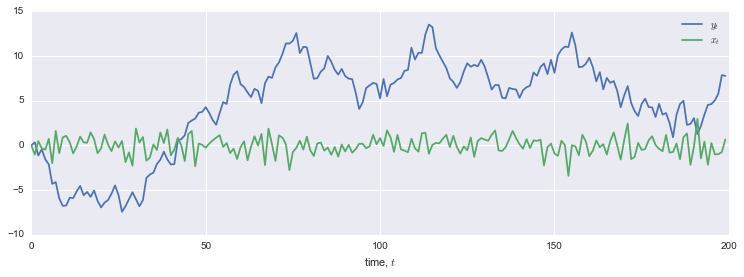

In [3]:
figsize(12.5, 4)
x_t = normal(0, 1, 200)
x_t[0] = 0
y_t = zeros(200)
for t in range(1, 200):
    y_t[t] = normal(y_t[t - 1], 1)

plot(y_t, label="$y_t$")
plot(x_t, label="$x_t$")
xlabel("time, $t$")
legend();

> One way to think of autocorrelation is "If I know the position of the series at time $s$, can it help me know where I am at time $t$?" In the series $x_t$, the answer is No. By construction, $x_t$ are random variables. If I told you that $x_2 = 0.5$, could you give me a better guess about $x_3$? No.
>  
> On the other hand, $y_t$ is autocorrelated. By construction, if I knew that $y_2 = 10$, I can be very confident that $y_3$ will not be very far from 10. Similarly, I can even make a (less confident guess) about $y_4$: it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about $y_5$, but again, I am less confident. Taking this to its logical conclusion, we must concede that as $k$, the lag between time points, increases the autocorrelation decreases. We can visualize this:

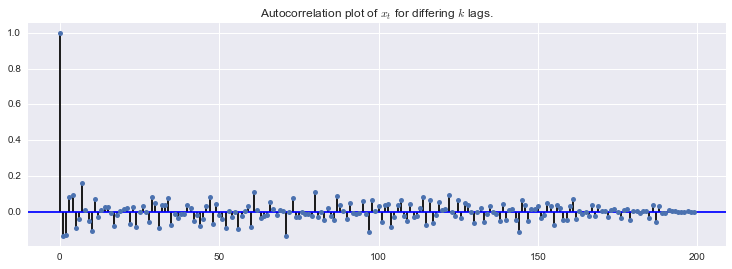

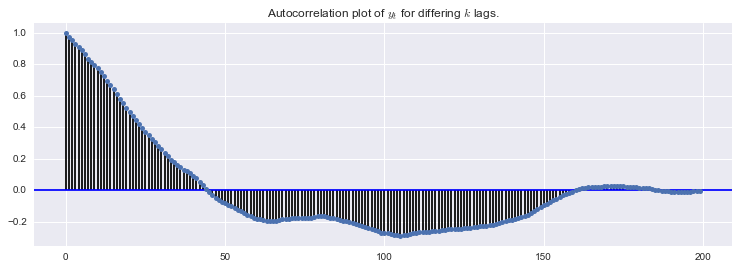

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x_t, alpha=None, title="Autocorrelation plot of $x_t$ for differing $k$ lags.");
plot_acf(y_t, alpha=None, title="Autocorrelation plot of $y_t$ for differing $k$ lags.");

> Notice that as $k$ increases, the autocorrelation of $y_t$ decreases from a very high point. Compare with the autocorrelation of $x_t$ which looks like noise (which it really is), hence we can conclude no autocorrelation exists in this series. 

### Definition  

We assume a time series, $\{y_t\}$, has the following properties:  

* $y_t$ is an observation of the level of $y$ at time $t$
* $\{y_t\}$ is time series, i.e., the collection of observations:
    * May extend back to $t = 0$ or $t = −\infty$, depending on the problem.
    * E.g., $t \in \{0, \dots, T\}$

### Assumptions  

We assume:  
* Discrete time:
    * Sampling at regular intervals
    * even if process is continuous
* Evenly spaced observations
* No missing observations

## Autoregressive Models

<!-- https://onlinecourses.science.psu.edu/stat501/node/358 -->

> A **time series** is a sequence of measurements of the same variable(s) made over time.  Usually the measurements are made at evenly spaced times - for example,  monthly or yearly. Let us first consider the problem in which  we have a $y$-variable measured as a time  series. As an example, we might have $y$ a measure of global temperature, with measurements observed each year. To emphasize that we have measured values over time, we use "$t$" as a subscript rather than the usual "$i$", $i.e.~y_t$ means $y$ measured in time period $t$. An **autoregressive model** is when a value from a time series is regressed on previous values from that same time series. for example, $y_t$ on $y_{t-1}$:  
>  
$$y_{t}=\beta_{0}+\beta_{1}y_{t-1}+\epsilon_{t}$$
>  
> In this regression model, the response variable in the previous time period has become the predictor and the errors have our usual assumptions about errors in a simple linear regression model. The **order** of an autoregression is the number of immediately preceding values in the series that are used to predict the value at the present time. So, the preceding model is a first-order autoregression, written as AR(1).  

> If we want to predict $y$ this year ($y_t$) using measurements of global temperature in the previous two years ($y_{t−1},y_{t−2}$), then the autoregressive model for doing so would be:
>  
$$y_{t}=\beta_{0}+\beta_{1}y_{t-1}+\beta_{2}y_{t-2}+\epsilon_{t}$$
>  
> This model is a second-order autoregression, written as AR(2), since the value at time $t$ is predicted from the values at times $t-1$ and $t-2$. More generally, a $k^{\textrm{th}}$-order autoregression, written as AR($k$), is a multiple linear regression in which the value of the series at any time $t$ is a (linear) function of the values at times $t-1,t-2,\ldots,t-k$.

### Autocorrelation and Partial Autocorrelation
> The coefficient of correlation between two values in a time series is called the **autocorrelation function** (**ACF**) For example the ACF for a time series $y_t$ is given by:  
>  
$$\mbox{Corr}(y_{t},y_{t-k})$$
>  
> This value of $k$ is the time gap being considered and is called the **lag**. A **lag 1** autocorrelation ($i.e.~k = 1$ in the above) is the correlation between values that are one time period apart. More generally, a **lag $k$** autocorrelation is the correlation between values that are $k$ time periods apart.
>  
> The ACF is a way to measure the linear relationship between an observation at time $t$ and the observations at previous times. 


<!--If we assume an AR($k$) model, then we may wish to only measure the association between $y_t$ and $y_{t−k}$ and filter out the linear influence of the random variables that lie in between $(i.e.~y_{t-1},y_{t-2},\ldots,y_{t-(k-1)})$, which requires a transformation on the time series. Then by calculating the correlation of the transformed time series we obtain the **partial autocorrelation function** (**PACF**).  
>  
> The PACF is most useful for identifying the order of an autoregressive model. Specifically, sample partial autocorrelations that are significantly different from 0 indicate lagged terms of $y$ that are useful predictors of $y_t$.
-->

### Example 1: Google Data

In [5]:
!pip install pandas_datareader

In [6]:
import pandas_datareader.data as web

In [7]:
start = datetime.datetime(2005, 2, 7)

end = datetime.datetime(2005, 7, 7)

goog = web.DataReader("GOOG", 'yahoo', start, end)

goog.describe()

,Open,High,Low,Close,Volume,Adj Close
count,105.000000,105.000000,105.000000,105.000000,1.050000e+02,105.000000
mean,224.379147,227.418199,221.583904,224.715624,2.529376e+07,112.245566
std,42.687043,43.569845,42.004527,42.976076,1.374880e+07,21.466571
min,175.300300,178.400306,172.570298,174.990304,7.438100e+06,87.407744
25%,187.730329,189.850325,185.070321,187.400315,1.527420e+07,93.606551
50%,217.820375,220.850371,214.260367,215.810363,2.092220e+07,107.797384
75%,269.430470,277.300478,267.430444,274.800477,3.318840e+07,137.262976
max,306.280512,309.250531,302.000514,304.100523,7.741340e+07,151.898363


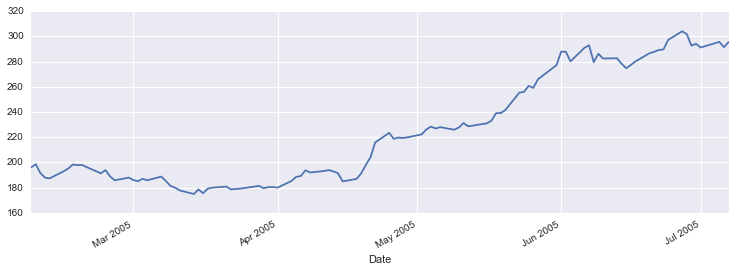

In [8]:
goog.Close.plot();

> Consecutive values appear to follow one another fairly closely, suggesting an autoregression model could be appropriate. 

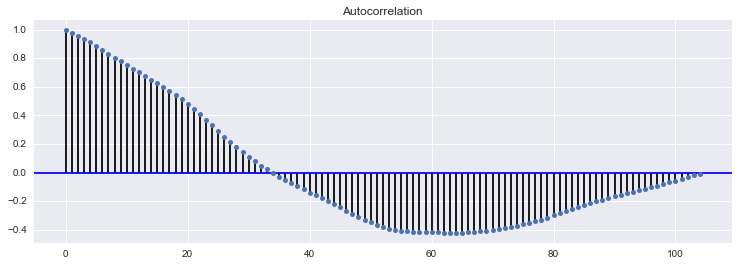

In [9]:
plot_acf(goog.Close, alpha=1.0);

This looks a lot like the ACF from our simulated data above.

> A start in evaluating whether an AR(1) might work is to plot values of the series against **lag 1 values** of the series.  Let $x_t$ denote the value of the series at any particular time $t$, so $x_{t-1}$ denotes the value of the series one time before time $t$.  That is, $x_{t-1}$ is the lag 1 value of $x_t$.  As a short example, here are the first five values in the earthquake series along with their lag 1 values:

In [10]:
google_stock = pd.DataFrame({'price': goog.Close})
google_stock['lag1price'] = google_stock.price.shift()
google_stock.head()

,price,lag1price
Date,,
2005-02-07,196.030335,NaN
2005-02-08,198.640336,196.030335
2005-02-09,191.580329,198.640336
2005-02-10,187.980317,191.580329
2005-02-11,187.400315,187.980317


Here’s a plot of $x_t$ versus $x_{t-1}$:

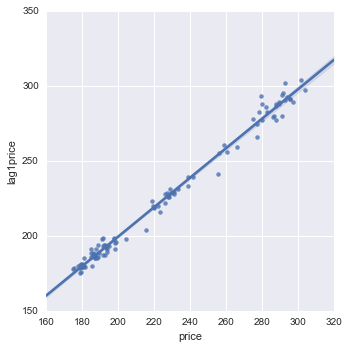

In [11]:
sns.lmplot('price', 'lag1price', google_stock);

> There appears to be a moderate linear pattern, suggesting that the first-order autoregression model $$ y_{t}=\beta_{0}+\beta_{1}y_{t-1}+\epsilon_{t}$$ could be useful.

In [12]:
ar1 = smf.ols('price ~ lag1price', data = google_stock).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     9502.
Date:                Mon, 03 Oct 2016   Prob (F-statistic):          1.71e-102
Time:                        11:29:47   Log-Likelihood:                -302.11
No. Observations:                 104   AIC:                             608.2
Df Residuals:                     102   BIC:                             613.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3585      2.353     -0.152      0.879      -5.025       4.308
lag1price      1.0059      0.010     97.476      0.000       0.985       1.026
==============================================================================
Omnibus:                        4.453   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                5.837
Skew:                          -0.003   Prob(JB):                       0.0540
Kurtosis:                       4.161   Cond. No.                     1.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the slope coefficient is significantly different from 0, so the lag 1 variable is a helpful predictor.  The $R^2$ value is quite strong at 98.9%.

#### Residual Analysis

> In traditional regression, a plot of residuals versus fits is a useful diagnostic tool. The ideal for this plot is a horizontal band of points. Following is a plot of residuals versus predicted values for our estimated model. It doesn’t show any serious problems.

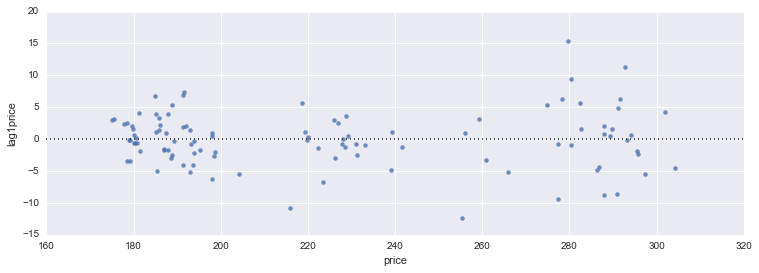

In [13]:
sns.residplot('price', 'lag1price', google_stock);

Another way to create an AR model, without having to manually create `lag` columns, is using `statsmodels.tsa.ar_model`:

In [14]:
from statsmodels.tsa.ar_model import AR

goog_ar1 = AR(goog.Close).fit(1)

In [15]:
def ar_summary(ar_model):
    return pd.DataFrame.from_items([('coef', ar_model.params), 
                                    ('std err', ar_model.bse),
                                    ('t', ar_model.tvalues), 
                                    ('P>|t|', ar_model.pvalues)])

ar_summary(goog_ar1)

,coef,std err,t,P>|t|
const,-0.358454,2.352889,-0.152346,0.878914
L1.Close,1.005871,0.010319,97.476447,0.000000


### Autocorrelation Function (ACF)

The autocorrelation function (ACF) for a series gives correlations between the series $y_t$ and lagged values of the series for lags of 1, 2, 3, and so on. The lagged values can be written as $y_{t-1},y_{t-2},y_{t-3}$ and so on. The ACF gives correlations between $y_t$ and $y_{t-1},y_{t-2},y_{t-3}$ and so on. 

The ACF can be used to identify the possible structure of time series data.  That can be tricky going as there often isn’t a single clear-cut interpretation of a sample autocorrelation function. The ideal for a sample ACF of residuals is that there aren’t any significant correlations for any lag.

Following is the ACF of the residuals for the Example 1, where we used an AR(1) model. The "lag" (time span between observations) is shown along the horizontal, and the autocorrelation is on the vertical. The shaded blue area indicate bounds for statistical significance. This is a good ACF for residuals.  Nothing is significant; that’s what we want for residuals.

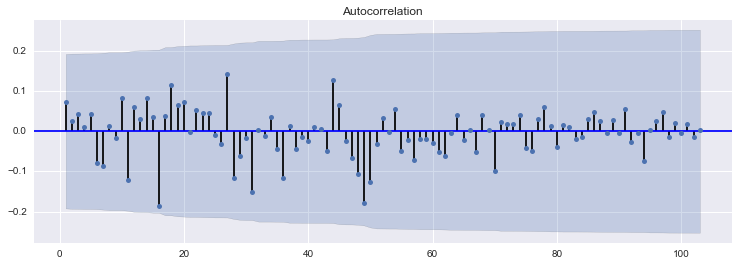

In [16]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(goog_ar1.resid, zero=False);

### Example 2: NYSE Data

<!--example adapted from _Introductor Econometrics_ by Jeffrey M. Woolridge-->
We can use this to test a version of the _efficient markets hypothesis_ (EMH). Let $y_t$ be the weekly percentage return (from Wednesday close to Wednesday close) on the New York Stock Exchange composite index. A strict form of the efficient markets hypothesis states that information observable to the market prior to week should not help to predict the return during week $t$. If we use only past information on $y$, the EMH is stated as  

$$E(y_t\mid y_{t-1},y_{t-2},\ldots)=E(y_t).$$

If this is false, then we could use information on past weekly returns to predict the current return. The EMH presumes that such investment opportunities will be noticed and will disappear almost instantaneously.  

One simple way to test this is to specify the AR(1) model as the alternative model. Then, the null hypothesis is easily stated as $H_0:\beta_1=0$. Under the null hypothesis, stock returns are serially uncorrelated, so we can safely assume that they are weakly dependent. We can use the usual OLS $t$ statistic for $\hat{\beta}_1$ to test $H_0:\beta_1=0$ against $H_1:\beta_1\neq0$.  

The weekly returns in NYSE are computed using data from January 1976 through March 1989. In the rare case that Wednesday was a holiday, the close at the next trading day was used. The average weekly return over this period was .196 in percentage form, with the largest weekly return being 8.45% and the smallest being 215.32% (during the stock market crash of October 1987).

,count,mean,std,min,25%,50%,75%,max
y,690.0,0.195784,2.114532,-15.321728,-1.099878,0.334362,1.546531,8.448762


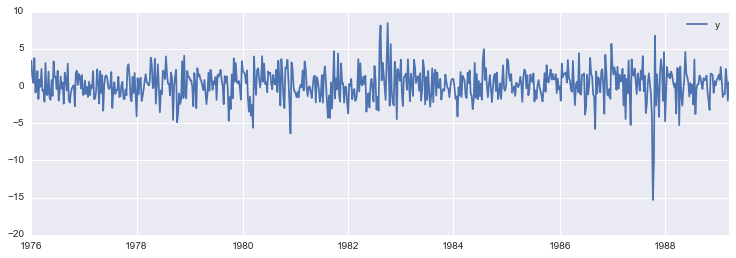

In [17]:
nyse = pd.read_csv('https://s3-us-west-2.amazonaws.com/dsci/6002/data/nyse.csv', index_col=0)
nyse.index = pd.date_range('January 1976', periods=len(nyse), freq='W')
nyse.plot()
nyse.describe().T

Estimation of the AR(1) model gives:

In [18]:
nyse_ar1 = AR(nyse.y).fit(1)
ar_summary(nyse_ar1)

,coef,std err,t,P>|t|
const,0.179634,0.080742,2.224792,0.026095
L1.y,0.058898,0.038023,1.549018,0.121377


The $t$ statistic for the coefficient on ${return}_{t-1}$ is about 1.55, and so $H_0:\beta_1=0$ cannot be rejected against the two-sided alternative, even at the 10% significance level. The estimate does suggest a slight positive correlation in the NYSE return from one week to the next, but it is not strong enough to warrant rejection of the efficient markets hypothesis.

In this example, using an AR(1) model to test the EMH might not detect correlation between weekly returns that are more than one week apart. It is easy to estimate models with more than one lag. For example, an _autoregressive model of order two_, or AR(2) model, is 

$$y_t=\beta_0+\beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t\\
E(\epsilon_t\mid y_{t-1},y_{t-2},\ldots)=0.$$ 

There are stability conditions on $\beta_1$ and $\beta_2$ that are needed to ensure that the AR(2) process is weakly dependent, but this is not an issue here because the null hypothesis states that the EMH holds: 

$$H_0:\beta_1=\beta_2=0$$

If we estimate an AR(2) model for ${return}_t$, we obtain:

In [19]:
nyse_ar2 = AR(nyse.y).fit(2)
ar_summary(nyse_ar2)

,coef,std err,t,P>|t|
const,0.185748,0.081150,2.288945,0.022083
L1.y,0.060315,0.038177,1.579865,0.114138
L2.y,-0.038075,0.038143,-0.998226,0.318170


The two lags are individually insignificant at the 10% level.

### Example 3: Cardiovascular Mortality
<!-- https://onlinecourses.science.psu.edu/stat510/node/60 -->
Here’s a time series of the cardiovascular mortality rate in Los Angeles County, 1970-1979

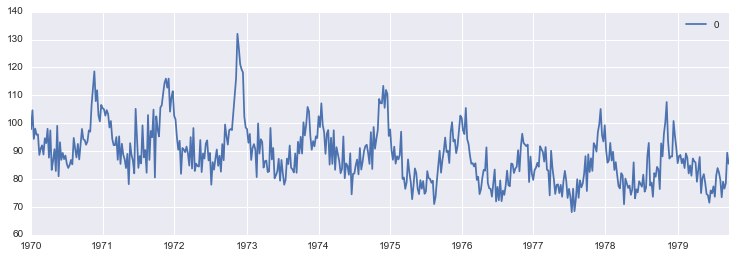

In [20]:
mort = pd.read_table('http://anson.ucdavis.edu/~shumway/cmort.dat', header=None)
mort.index = pd.date_range('1970', periods=len(mort), freq='W')
mort.plot();

There is a slight downward trend, so the series may not be stationary.

### Stationary Series

> For an ACF to make sense, the series must be a _weakly stationary_ series.  This means that the autocorrelation for any particular lag is the same regardless of where we are in time.
> 
> **Definition:** A series $x_t$ is said to be **(weakly) stationary** if it satisfies the following properties:
> 
* The mean $E(x_t)$ is the same for all $t$.
* The variance of $x_t$ is the same for all $t$.
* The covariance (and also correlation) between $x_t$ and $x_{t-h}$ is the same for all $t$.
> 
> Many stationary series have recognizable ACF patterns. Most series that we encounter in practice, however, are not stationary. A continual downward trend, for example, is a violation of the requirement that the mean is the same for all $t$. Distinct seasonal patterns also violate that requirement. 

Returning to Example 3, to create a (possibly) stationary series, we’ll examine the **first differences** $y_t = x_t - x_{t-1}$. This is a common time series method for creating a de-trended series and thus potentially a stationary series. Think about a straight line – there are constant differences in average $y$ for each change of 1-unit in $x$.

The time series plot of the first differences is the following:

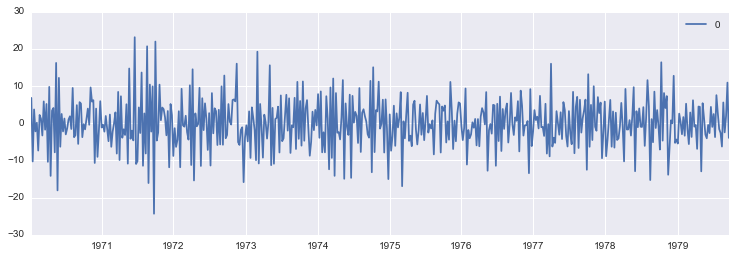

In [21]:
mortdiff = mort.diff().dropna()
mortdiff.plot();

The following plot is the sample estimate of the autocorrelation function of 1st differences:

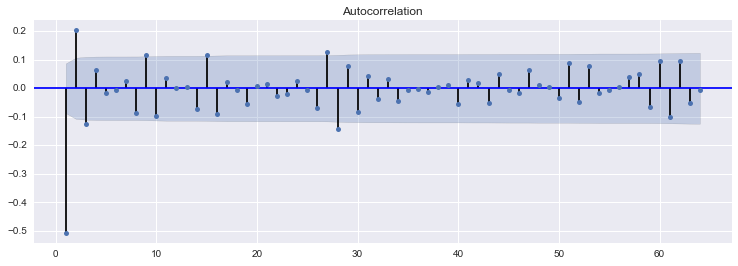

In [22]:
plot_acf(mortdiff, lags=range(1,65));

In [23]:
pd.Series(acf(mortdiff))[1:6]

1   -0.506029
2    0.205100
3   -0.126110
4    0.062476
5   -0.015190
dtype: float64

> This looks like the pattern of an AR(1) with a negative lag 1 autocorrelation.  Note that the lag 2 correlation is roughly equal to the squared value of the lag 1 correlation.  The lag 3 correlation is nearly exactly equal to the cubed value of the lag 1 correlation, and the lag 4 correlation nearly equals the fourth power of the lag 1 correlation.  Thus an AR(1) model may be a suitable model for the first differences $y_t = x_t - x_{t-1}$.

Thus:

In [24]:
mort_ar1 = AR(mortdiff[0]).fit(1)
ar_summary(mort_ar1)

,coef,std err,t,P>|t|
const,-0.046272,0.258996,-0.178659,8.582055e-01
L1.y,-0.506364,0.038376,-13.194874,9.391158e-40
